# Алгоритмы кластеризации

Основная задача этого задания - реализация одного из алгоритмов кластеризации.
Кроме того, необходимо будет проверить корректность работы алгоритма на тестовых данных, проверить работу алгоритма на данных различной природы, подбирать параметры алгоритма.

In [384]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import SpectralClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


## Реализация алгоритма

Необходимо выбрать и реализовать самостоятельно один из следующих алгоритмов кластеризации:
* Агломеративная иерархическая кластеризация с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)
* DBSCAN. (параметры - epsilon, min_pts) - нужно самостоятельно разобрать и применить критерий качества для DBSCAN
* OPTICS(\*). (параметры - epsilon, min_pts)
* Gaussian Mixture Model(\*\*) с использованием maximum a-posteriori для выбора кластера (параметр - k)
* Spectral Clustering

(\*) - алгоритм не был разобран на занятии. Выбирайте этот пункт только если уверенно умеете программировать и хотите разобраться с более сложной идеей, чем DBSCAN  
(\*\*) - алгоритм не был разобран на занятии, задание повышенной сложности. Выбирайте этот пункт только если хотите разобраться со сложным математическим обоснованием и точно уверены, что сможете запрограммировать и отладить.

## Интерфейс
Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [385]:
from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):
    
    #Our Clustering object has some parameters that we specify during its construction
    #similiarity_graph -> this parameter specifies how we construct the graph according to our data
    #                     if similiarity_graph is set to "epsilion_neighborhood", then we connect
    #                     two data points iff the Euclidean distance between them is less then parametr eps
    #                     if similiarity_graph is set to "k-neighbors" we connect each data point to its k nearest
    #                     neighbors in Euclidean distance, in this case one must also provide value for k.
    #                     if similiarity_graph is set to "fully_connected", the we connect all data points with
    #                     each other but give different weights to edges according to the similiarity measure of
    #                     that data points, in this case one should also provide value for parameter sigma, 
    #                     which is used to calculate the similiarity measure(see later)
    #eps -> when similiarity_graph is set to "epsilion_neighborhood" we to datasets are connected with an edge iff
    #       their Eucidien distance is less then eps, otherwise this parameter is ignored
    #k   -> when similiarity_graph is set to "k_neighbos" this parameters defines k, otherwise it is ignored
    #clusters -> user specifies how many clusters he feels there should be, in case of reliable value
    #            efficiency of algorythm encreases, if clusters is set to None algorythm generates an optimal
    #            value of clusters using some methods(see later)
    #sigma    -> When similiarity_graph is set to "fully_connected"  from this parameter a similiaarity function is
    #            constructed, otherwise this parameter is ignored.
    def __init__(self, similiarity_graph = "epsilion_neighborhood",
                       eps = 0.1,
                       k = None,
                       clusters = None,
                       sigma = None):
        
        self.similiarity_graph = similiarity_graph
        self.eps = eps
        self.clusters = clusters
        self.sigma = sigma       
        self.k = k
        
        return
        
    def fit(self, x, y=None):
        
        #we construct adjacency matrix of our graph and then we evaluate the laplacian matrix
        self.x = np.array(x)
        self.adjacency_matrix = self.adjacency_matrix()
        self.laplacian_matrix = self.laplacian_matrix()   
        
        #we find the eigenvalues of laplacian matrix
        #because laplacian matrix is symetric and positive semidefinite it has 
        #n positive eigen values, we collect them in encreasing order, also
        #eigenvectors corresponding to eigenvalues are also evaluated.
        #here np.linalg.eigh is used instead of np.linalg.eig, to be suar that 
        #because of rounding errors we won't get complex eigenvalues.
        eigen_vals, eigen_vecs = np.linalg.eigh(self.laplacian_matrix)
                
        increasing_order = np.argsort(eigen_vals)
        eigen_vals = eigen_vals[increasing_order]
        eigen_vecs = eigen_vecs[:, increasing_order]
        
        self.eigen_vals = eigen_vals
        self.eigen_vecs = eigen_vecs      
        
        #as said before if user doesn't define this parameter, algorythms provide an optimal value itself
        if self.clusters is None:
            self.clusters = self.optimal_clusters()
        
        #this is the main step of our algorythms where clustering is done
        #the main ide is that, we don't cluster the data points
        #we cluster eigeb vectors, which contain lot of more information then just 
        #data points
        self.model = KMeans(n_clusters = self.clusters)
        self.model.fit(eigen_vecs[:,0:self.clusters])

        return self
    
    def predict(self, x):          
           
        return self.model.labels_
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)
    
    def adjacency_matrix(self):
        
        n = len(self.x)
        adjacency_matrix = np.zeros((n, n))
        
        if self.similiarity_graph == "epsilion_neighborhood":
        #in this case the adjacency matrix is rather simple 
        #if two datapoints are closer then eps we connect them
        #in this case edges do not have weights, so the adjacecny matrix 
        #is symmetric matrix containing only zeros and ones
            for i in range(1, n):
                for j in range(0, i):
                     if np.linalg.norm(self.x[i]-self.x[j]) < self.eps:
                        adjacency_matrix[i][j] = 1
                        adjacency_matrix[j][i] = 1                        
        elif self.similiarity_graph == "k_neighbors":
        #in this case we connect data point to its k nearist neighbors in Euclidean metrics
        #as we notice in this case we end up with directed graph
        #there are several ways to get ride of directed edges
        #in our implementation we just clear the arrows on directed edges
            nbrs = NearestNeighbors(n_neighbors=self.k, algorithm='ball_tree').fit(self.x)
        #this line returns the directed graph's adjacency matrix
            adjacency_matrix = nbrs.kneighbors_graph(self.x).toarray()            
            for i in range(1, n):
                for j in range(0, i):
                    if adjacency_matrix[i][j] == 1 or adjacency_matrix[j][i] == 1:
        #here we get rid of directedness, and also we give weights to edges
                        dist = np.linalg.norm(self.x[i]-self.x[j])
                        adjacency_matrix[i][j] = dist
                        adjacency_matrix[j][i] = dist
            for i in range(n):
                adjacency_matrix[i][i] = 0
        #here we dont want to connect vertex with itself
        elif  self.similiarity_graph == "fully_connected":
            for i in range(1, n):
                for j in range(0, i):
        #here all vertices are connected, but all edges have different weights
        #you can notice that the weights are counted according to special simliliarity measure
                    adjacency_matrix[i][j] = np.exp(-np.linalg.norm(self.x[i]-self.x[j])**2 / (2*self.sigma**2))
                    adjacency_matrix[j][i] = np.exp(-np.linalg.norm(self.x[i]-self.x[j])**2 / (2 *self.sigma**2))
                    
        return adjacency_matrix
                        
    def laplacian_matrix(self):
        #Here we evaluate Laplacian matrix(L = D - W)
        #where W is adjacency matrix and D is degree matrix
        #degree matrix is a diagonal matrix, and D[i][i] is the sum of elements in i-th
        #row of adjacency matrix
        n = len(self.x)        
        degree_matrix = np.zeros((n, n))
                               
        for i in range(0, n):
            degree_matrix[i][i] = np.sum(self.adjacency_matrix[i])       
        
        return degree_matrix - self.adjacency_matrix
    
    def optimal_clusters(self):
        #this is one of the recomended ways to come up with a good number of clusters
        #the number of eigenvalues before the drasting change of their values is returned
        #remember that eigen_vals is a sorted array.
        return np.argmax(np.diff(self.eigen_vals))+1     

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

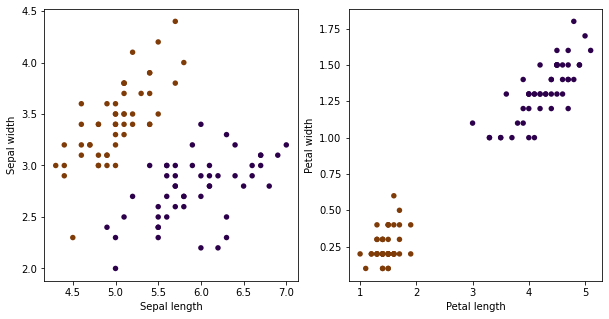

In [386]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики сильно отличается от 1, предлагается поработать над улучшением реализации своего алгоритма. 

In [387]:
#we show the result whith similiarity graph is set to default which is epsilion_neighborhood
#we only tuned parametr eps, as we see algorythm found the exact value of different clusters

spectral_clustering = Clustering(eps = 1)
pred_iris = spectral_clustering.fit_predict(x_iris)
print("Predicted labels are: ", pred_iris)
print("Original labels are: ", y_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Predicted labels are:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Original labels are:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Adjusted Rand index for iris is: 1.00


In [388]:
#we show the result whith similiarity graph is set to k-neighbors
#we only tuned parametr k, as we see algorythm found the exact value of different clusters

spectral_clustering = Clustering(similiarity_graph = "k_neighbors",  k = 24)
pred_iris = spectral_clustering.fit_predict(x_iris)
print("Predicted labels are: ", pred_iris)
print("Original labels are: ", y_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Predicted labels are:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Original labels are:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Adjusted Rand index for iris is: 1.00


In [389]:
#we show the result whith similiarity graph is set to fully_connected
#we only tuned parametr sigma, as we see algorythm found the exact value of different clusters

spectral_clustering = Clustering(similiarity_graph = "fully_connected",  sigma = 1)
pred_iris = spectral_clustering.fit_predict(x_iris)
print("Predicted labels are: ", pred_iris)
print("Original labels are: ", y_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Predicted labels are:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Original labels are:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Adjusted Rand index for iris is: 1.00


Подобрать параметры модели с использованием эвристик и критериев качества. 

Критерий локтя:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

Для DBSCAN применяется эвристика по подсчету среднего расстояния до min-pts точек, их сортировки, далее применяется критерий локтя (описание https://habrahabr.ru/post/322034/ или http://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров, а так же при необходимости изменить этот код (для DBSCAN). На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров. Возможно, необходимо построить такую визуализацию несколько раз.

In [ ]:
ks = range(1, 21)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering()
    y = cls.fit_predict(x)
    criteria[i] = quality(x, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать с помощью реализованного алгоритма данные, используемые для демонстраций на предыдущих занятиях. Предлагается сделать сравнение с реализацией из sklearn.

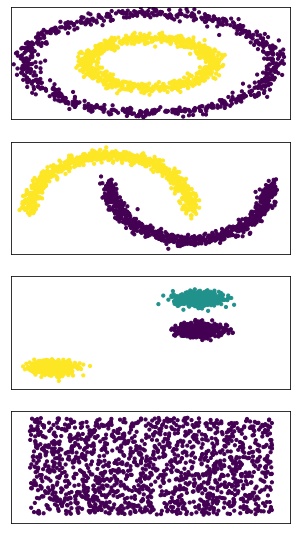

In [390]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
%matplotlib inline

#here is the result of custom algorythm,
#the most difficulte case was the case of cocentric circles
#but k_neighbors did it perfectly

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

plt.figure(figsize=(2 + 3, 9.5))

data_to_clusters = [(noisy_circles,2), (noisy_moons,2), (blobs,3), (no_structure, 1)]
for i_dataset, dataset_to_cluster in enumerate(data_to_clusters):
    X, y = dataset_to_cluster[0]
    number_of_clusters = dataset_to_cluster[1]
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    cls = Clustering(similiarity_graph = "k_neighbors", k = 24, clusters = number_of_clusters)
    Y = cls.fit_predict(X)
    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10, c = Y)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()

c:\users\admin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
c:\users\admin\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


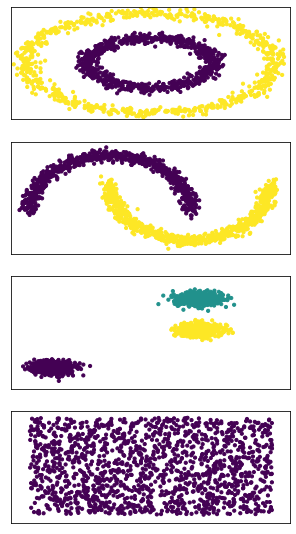

In [391]:
#here is the result of sklearn algorythm
#which is similiar to the results of custom algorythm
#but it works really fast!!
plt.figure(figsize=(2 + 3, 9.5))

for i_dataset, dataset_to_cluster in enumerate(data_to_clusters):
    X, y = dataset_to_cluster[0]
    number_of_clusters = dataset_to_cluster[1]
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    cls = SpectralClustering(n_clusters=number_of_clusters, affinity = "nearest_neighbors", n_neighbors = 24).fit(X)
    Y = cls.labels_
    # plot
    plt.subplot(4, 1, i_dataset + 1)
    plt.scatter(X[:, 0], X[:, 1], s=10, c = Y)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.xticks(())
    plt.yticks(())

plt.show()